# Instâncias reais

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).


* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

In [2]:
import sys
import os
import pandas as pd
import numpy as np


import joblib
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve
import seaborn as sns

import matplotlib.pyplot as plt

import shap

from pyod.models.ecod import ECOD

from pyod.models.suod import SUOD

from pyod.models.xgbod import XGBOD

from pyod.models.loda import LODA

from pyod.models.pca import PCA

from sklearn.neighbors import LocalOutlierFactor

from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

from sklearn.neighbors import LocalOutlierFactor

from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.pipeline import make_pipeline
from sklearn.svm import OneClassSVM

import plotly.graph_objects as go

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


In [3]:

import plotly.graph_objects as go

In [4]:
def metrics(y_test, y_pred):
    cm = list()
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test, y_pred, digits=5))  


    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    print("Specificity:", TN/(TN+FP))


    roc_auc = roc_auc_score(y_test, y_pred, multi_class = 'ovr', average=None)
    gini = 2*roc_auc -1
    print("Gini: ",gini)
    print("ROC AUC:: ",roc_auc)

In [5]:
class ToDataFrameTransformer(BaseEstimator, TransformerMixin):
    """
    Transformador para converter arrays NumPy em DataFrames, mantendo os nomes das colunas.
    """
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        # Não há nada para ajustar, apenas retorna o próprio objeto
        return self

    def transform(self, X):
        # Converte o array NumPy em DataFrame com os nomes das colunas fornecidos
        if self.columns is not None:
            return pd.DataFrame(X, columns=self.columns)
        return pd.DataFrame(X)

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [6]:
train = pd.read_parquet('./dataset/train_temp.parquet.gzip') 
test = pd.read_parquet('./dataset/test_temp.parquet.gzip') 

In [7]:
VARS = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'QGL']

In [8]:
train.head()

P-PDG       P-TPT     T-TPT  P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  QGL  \
7365884    0.0  18433410.0  116.8718  9397031.0   74.80031   -300917.8  0.0   
7365885    0.0  18433410.0  116.8718  9397031.0   74.80031   -300917.8  0.0   
7365886    0.0  18433410.0  116.8718  9397032.0   74.80031   -300917.8  0.0   
7365887    0.0  18433410.0  116.8718  9397033.0   74.80031   -300917.8  0.0   
7365888    0.0  18433410.0  116.8718  9397033.0   74.80031   -300917.8  0.0   

                  timestamp        well  target  
7365884 2014-01-24 09:33:03  WELL-00001       1  
7365885 2014-01-24 09:33:04  WELL-00001       1  
7365886 2014-01-24 09:33:05  WELL-00001       1  
7365887 2014-01-24 09:33:06  WELL-00001       1  
7365888 2014-01-24 09:33:07  WELL-00001       1

## Isolation Forest

In [9]:
with open('./models/pipeline_iForest.pkl', 'rb') as f:
    iforest = pickle.load(f) 

In [10]:
iforest

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG', 'P-TPT', 'T-TPT',
                                                 'P-MON-CKP', 'T-JUS-CKP',
                                                 'P-JUS-CKGL', 'QGL'])),
                ('estimator',
                 IsolationForest(contamination=0.05, random_state=42))])

In [11]:
y_pred = iforest.predict(test[VARS])
test['iForest'] = np.where(y_pred == -1, 1, 0)  

In [12]:
y_pred = iforest.predict(train[VARS])
train['iForest'] = np.where(y_pred == -1, 1, 0)  

In [13]:
test['scores_forest']=-iforest.decision_function(test[VARS])

In [14]:
train['scores_forest'] = -iforest.score_samples(train[VARS])

In [15]:
test['iForest'].value_counts()

iForest
1    1288346
0     933454
Name: count, dtype: int64

<Axes: xlabel='scores_forest', ylabel='Density'>

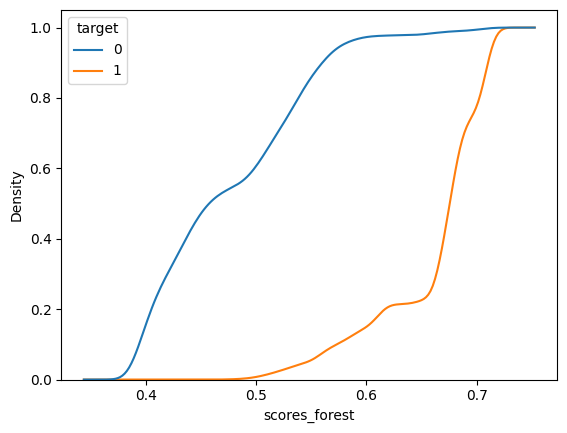

In [16]:
sns.kdeplot(
    data=train.sample(frac=0.01), x="scores_forest", hue=train.target,
    cumulative=True, common_norm=False, common_grid=True,
)

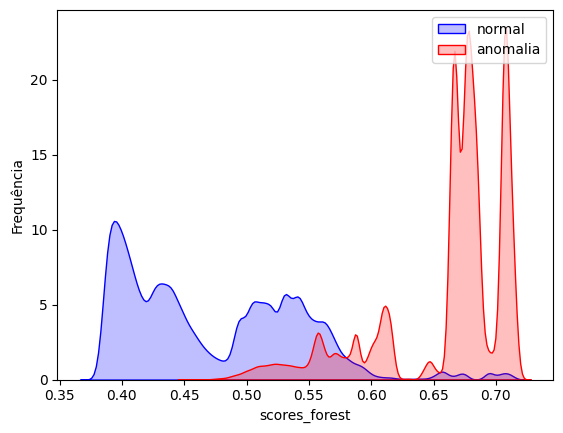

In [17]:
g = sns.kdeplot(train["scores_forest"][(train["target"] == 0) & (train["scores_forest"].notnull())], color="Blue", fill = True)
g = sns.kdeplot(train["scores_forest"][(train["target"] == 1) & (train["scores_forest"].notnull())], ax =g, color="Red", fill= True)

g.set_xlabel("scores_forest")
g.set_ylabel("Frequência")
g = g.legend(['normal', 'anomalia'])

<Axes: xlabel='scores_forest', ylabel='Density'>

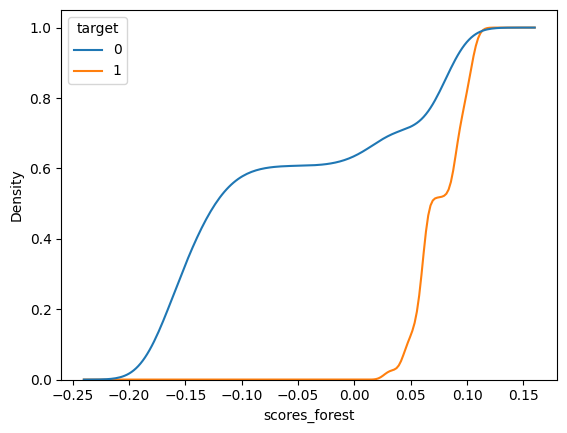

In [18]:
sns.kdeplot(
    data=test.sample(frac=0.01), x="scores_forest", hue=test.target,
    cumulative=True, common_norm=False, common_grid=True,
)

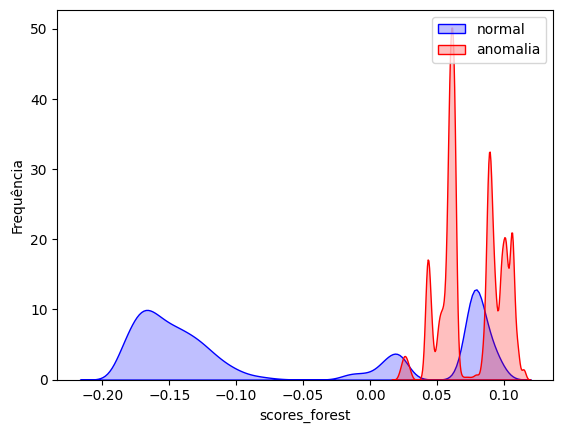

In [19]:
g = sns.kdeplot(test["scores_forest"][(test["target"] == 0) & (test["scores_forest"].notnull())], color="Blue", fill = True)
g = sns.kdeplot(test["scores_forest"][(test["target"] == 1) & (test["scores_forest"].notnull())], ax =g, color="Red", fill= True)

g.set_xlabel("scores_forest")
g.set_ylabel("Frequência")
g = g.legend(['normal', 'anomalia'])

### Metrics

Classification Report: 
               precision    recall  f1-score   support

           0    0.94546   0.95001   0.94773   5872276
           1    0.90170   0.89325   0.89746   3014901

    accuracy                        0.93075   8887177
   macro avg    0.92358   0.92163   0.92259   8887177
weighted avg    0.93061   0.93075   0.93067   8887177

Specificity: 0.9500071181940358
Gini:  0.8432603294935113
ROC AUC::  0.9216301647467556


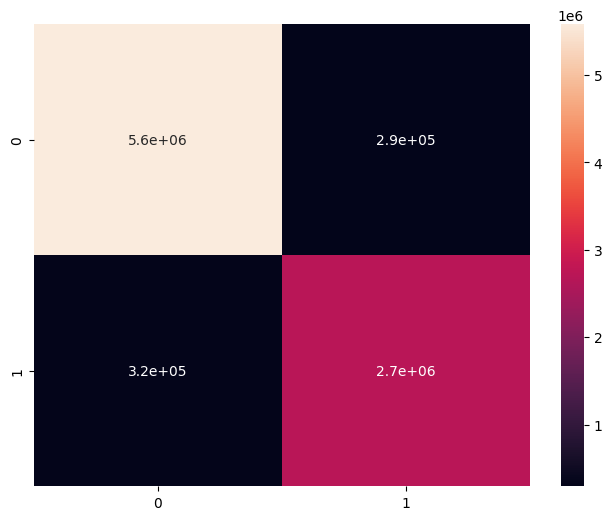

In [20]:
metrics(train.target, train.iForest)

Classification Report: 
               precision    recall  f1-score   support

           0    1.00000   0.62497   0.76920   1493608
           1    0.56521   1.00000   0.72222    728192

    accuracy                        0.74788   2221800
   macro avg    0.78261   0.81248   0.74571   2221800
weighted avg    0.85750   0.74788   0.75381   2221800

Specificity: 0.6249658544946197
Gini:  0.6249658544946197
ROC AUC::  0.8124829272473099


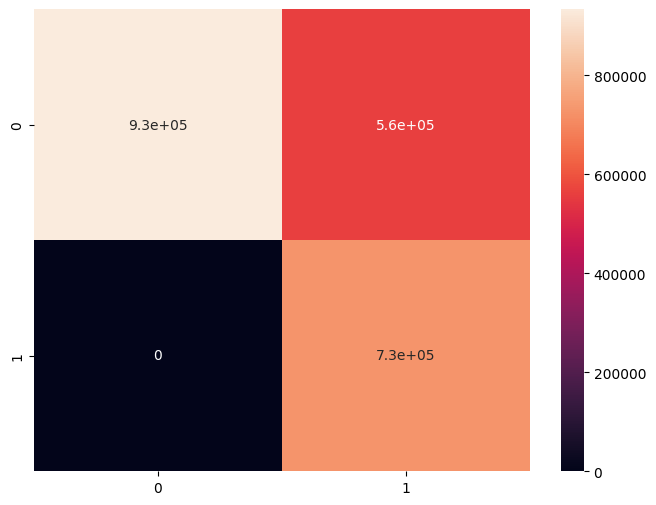

In [21]:
metrics(test.target, test.iForest)

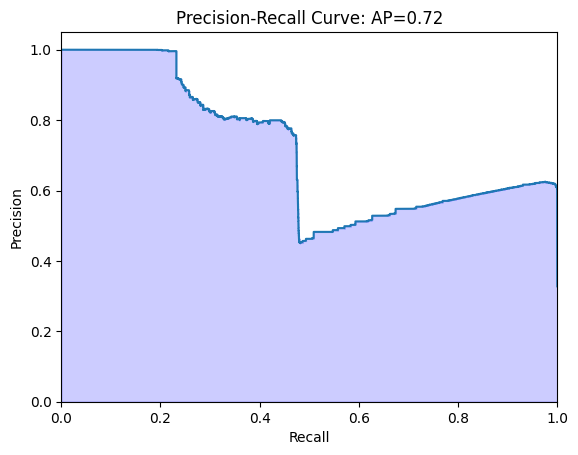

In [22]:
# Calcular as precisões, recalls e limiares
precision, recall, thresholds = precision_recall_curve(test.target, test.scores_forest)

# Calcular a Average Precision (AP)
average_precision = average_precision_score(test.target, test.scores_forest)

# Plotar a curva Precision-Recall
plt.figure()
plt.step(recall, precision, where='post')

# Adicionar a linha de base (linhas de zero para precisão e recall)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

# Título e rótulos dos eixos
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve: AP={average_precision:0.2f}')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

### Explainable

In [23]:
test_sample = test.sample(frac=0.05, random_state=45)
test_sample_shap = test_sample[VARS]
test_sample_shap.shape

(111090, 7)

In [87]:
test_sample_shap.head()

P-PDG       P-TPT     T-TPT   P-MON-CKP  T-JUS-CKP  \
1365893  -6.887865e+06   9663066.0  118.4939   1590471.0   83.71794   
10740299 -1.180116e+42  20787460.0  117.9016  10101000.0   70.89400   
1472095  -6.887865e+06   9654070.0  118.4533   1424296.0   83.07838   
10746609 -1.180116e+42  20787460.0  117.9162  10094150.0   70.92538   
1631158  -6.887865e+06   9615695.0  118.4985   1213798.0   83.28349   

          P-JUS-CKGL  QGL  
1365893    -137539.4  0.0  
10740299   4048624.0  0.0  
1472095    -147999.8  0.0  
10746609   4061716.0  0.0  
1631158    -142259.4  0.0

In [88]:
exp = shap.TreeExplainer(iforest[2]) #Explainer
test_transform = iforest[1].transform((iforest[0].transform(test_sample_shap)))
shap_values = exp.shap_values(test_transform)  #Calculate SHAP values
shap.initjs()

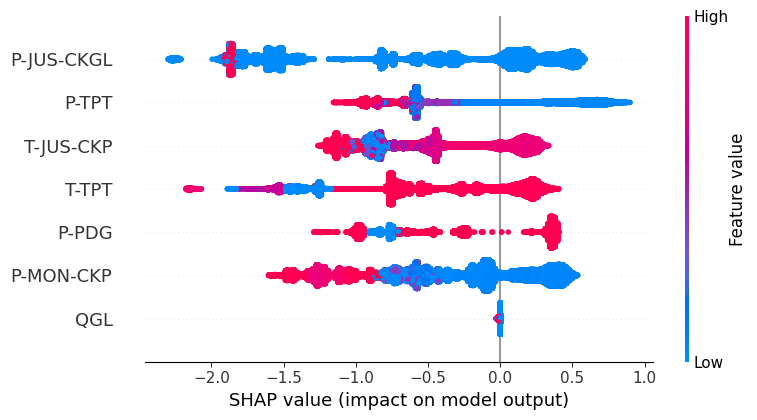

In [89]:
shap.summary_plot(shap_values, test_transform)

In [90]:
test_sample_shap.head(5)

P-PDG       P-TPT     T-TPT   P-MON-CKP  T-JUS-CKP  \
1365893  -6.887865e+06   9663066.0  118.4939   1590471.0   83.71794   
10740299 -1.180116e+42  20787460.0  117.9016  10101000.0   70.89400   
1472095  -6.887865e+06   9654070.0  118.4533   1424296.0   83.07838   
10746609 -1.180116e+42  20787460.0  117.9162  10094150.0   70.92538   
1631158  -6.887865e+06   9615695.0  118.4985   1213798.0   83.28349   

          P-JUS-CKGL  QGL  
1365893    -137539.4  0.0  
10740299   4048624.0  0.0  
1472095    -147999.8  0.0  
10746609   4061716.0  0.0  
1631158    -142259.4  0.0

In [94]:
shap.force_plot(exp.expected_value, shap_values[250],features =test_transform.iloc[250,:] ,feature_names =test_transform.columns)

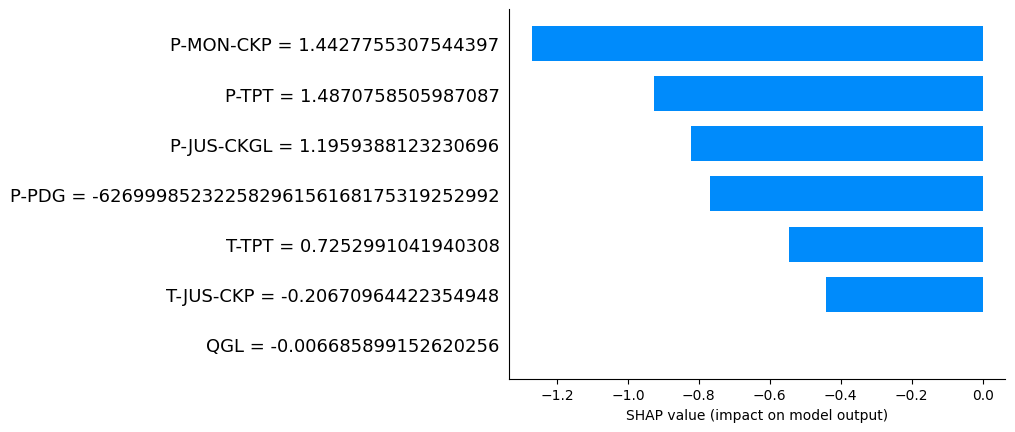

In [30]:
shap.bar_plot(shap_values[3],features =test_transform.iloc[1,:] ,feature_names =test_transform.columns)

## TSNE

In [24]:
train_sample_tsne = train.sample(frac=0.002, random_state=48)
train_sample_tsne.shape

(17774, 12)

In [25]:
train_sample_tsne_transformed = iforest[1].transform((iforest[0].transform(train_sample_tsne[VARS])))

In [26]:
tsne = TSNE(n_components=3, verbose=1, perplexity=30, n_iter=1000, n_jobs=-1)

In [27]:
X_reduce = tsne.fit_transform(train_sample_tsne_transformed)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 17774 samples in 0.164s...
[t-SNE] Computed neighbors for 17774 samples in 0.901s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17774
[t-SNE] Computed conditional probabilities for sample 2000 / 17774
[t-SNE] Computed conditional probabilities for sample 3000 / 17774
[t-SNE] Computed conditional probabilities for sample 4000 / 17774
[t-SNE] Computed conditional probabilities for sample 5000 / 17774
[t-SNE] Computed conditional probabilities for sample 6000 / 17774
[t-SNE] Computed conditional probabilities for sample 7000 / 17774
[t-SNE] Computed conditional probabilities for sample 8000 / 17774
[t-SNE] Computed conditional probabilities for sample 9000 / 17774
[t-SNE] Computed conditional probabilities for sample 10000 / 17774
[t-SNE] Computed conditional probabilities for sample 11000 / 17774
[t-SNE] Computed conditional probabilities for sample 12000 / 17774
[t-SNE] Computed conditional probabilities for sam

In [28]:
tsne_result_df = pd.DataFrame({'tsne_1': X_reduce[:,0], 'tsne_2': X_reduce[:,1], 'tsne_3': X_reduce[:,0]})

tsne_result_df = tsne_result_df.reset_index(drop=True)
data_tsne = train_sample_tsne.reset_index(drop=True)

data_tsne = pd.concat([data_tsne, tsne_result_df], axis=1)
# data2= data2[data2['CONJUNTO']=='test']
data_tsne.head()

P-PDG       P-TPT      T-TPT  P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  \
0         0.0   7692329.0  115.98580  1392323.0   71.00699   2332164.0   
1  23428230.0  13984480.0   55.97573  2607340.0   37.41902  20036340.0   
2         0.0  14229420.0  116.58940  6109810.0   69.11475   3007766.0   
3  32308910.0  12881370.0   86.08977  5798349.0   30.51202  16627500.0   
4  23406160.0  13769710.0   56.46887  2372113.0   37.57725  19696220.0   

        QGL           timestamp        well  target  iForest  scores_forest  \
0  0.000000 2017-02-15 22:05:03  WELL-00002       0        0       0.489431   
1  1.875875 2017-09-23 19:47:16  WELL-00014       1        1       0.669879   
2  0.000000 2017-05-28 10:25:30  WELL-00001       0        0       0.437528   
3  0.000000 2014-03-15 12:00:10  WELL-00017       1        1       0.684785   
4  1.503259 2017-09-15 21:14:52  WELL-00014       1        1       0.666385   

      tsne_1     tsne_2     tsne_3  
0   3.590950  -2.340828   3.590950  
1  31.532644  -5.972567  31.532644  
2   6.107171 -11.446284   6.107171  
3  19.558762   4.912278  19.558762  
4  24.816570 -16.530167  24.816570

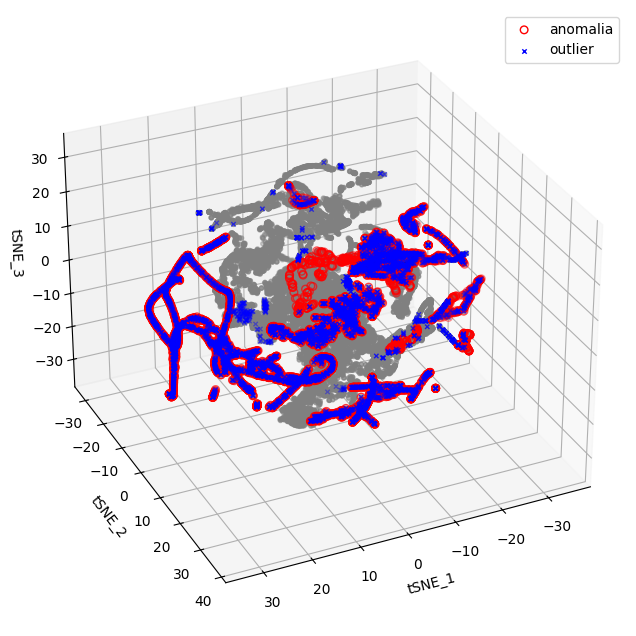

In [44]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("tSNE_3")
ax.set_ylabel("tSNE_2")
ax.set_xlabel("tSNE_1")

# Plot the reduced dimensionality data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=10, lw=1, c='grey')

# Plot circles around the predicted outliers
ax.scatter(X_reduce[data_tsne.target == 1, 0], X_reduce[data_tsne.target == 1, 1], zs=X_reduce[data_tsne.target == 1, 2],
           lw=1, facecolors="none", edgecolors="red", s=30, label="anomalia")

# Plot x's for the ground truth outliers
ax.scatter(X_reduce[data_tsne.iForest == 1, 0], X_reduce[data_tsne.iForest == 1, 1], zs=X_reduce[data_tsne.iForest == 1, 2],
           lw=1, s=10, marker="x", c="blue", label="outlier")

ax.legend()

# Rotacionar o gráfico
ax.view_init(elev=30, azim=65)  # Elevação e azimute em graus

plt.show()

## Controle Estatístico de Processos

In [22]:
train.groupby("well")["target"].sum()

well
WELL-00001    410321
WELL-00002    878303
WELL-00006    175174
WELL-00007     68816
WELL-00009      5358
WELL-00010    481363
WELL-00014    559787
WELL-00015     43848
WELL-00016     16372
WELL-00017    305830
WELL-00018     69729
Name: target, dtype: int64

In [23]:
train.groupby("well")["target"].count()

well
WELL-00001    1650210
WELL-00002    3615177
WELL-00006    2070687
WELL-00007      68816
WELL-00009       5358
WELL-00010     481363
WELL-00014     559787
WELL-00015      43848
WELL-00016      16372
WELL-00017     305830
WELL-00018      69729
Name: target, dtype: int64

In [24]:
spc_sample_train = train[train['well']=='WELL-00006']
spc_sample_train.shape

(2070687, 12)

In [25]:
# Calcular o desvio padrão dos escores no conjunto de treino sem anomalias
train_sample_ewma = train[(train['target'] == 0)&(train['well']=='WELL-00006')].reset_index(drop=True)
# train_sample_ewma = spc_sample_train[(spc_sample_train['target'] == 0)].reset_index(drop=True)
#.sample(frac=0.01, random_state=51).reset_index(drop=True)
escores_train = train_sample_ewma['scores_forest']

# Definir parâmetros EWMA
lambda_ = 0.1  # Fator de suavização, geralmente entre 0.1 e 0.3
L = 3  # Multiplicador para limites de controle

# Calcular EWMA para os dados de treino sem anomalias
ewma_train = np.zeros_like(escores_train)
ewma_train[0] = escores_train[0]
for i in range(1, len(escores_train)):
    ewma_train[i] = lambda_ * escores_train[i] + (1 - lambda_) * ewma_train[i-1]

# Calcular desvio padrão dos escores no conjunto de treino sem anomalias
sigma = np.std(escores_train)

In [26]:
sigma

0.03116340495811483

In [27]:
test.groupby("well")["target"].sum()

well
WELL-00001         0
WELL-00002         0
WELL-00006    354782
WELL-00007      2835
WELL-00009      1340
WELL-00010    120341
WELL-00014    139947
WELL-00015     10963
WELL-00016      4093
WELL-00017     76458
WELL-00018     17433
Name: target, dtype: int64

In [28]:
test.groupby("well")["target"].count()

well
WELL-00001    412553
WELL-00002    903795
WELL-00006    517672
WELL-00007     17205
WELL-00009      1340
WELL-00010    120341
WELL-00014    139947
WELL-00015     10963
WELL-00016      4093
WELL-00017     76458
WELL-00018     17433
Name: target, dtype: int64

In [29]:
spc_sample_test = test[test['well']=='WELL-00006']
spc_sample_test.shape

(517672, 12)

In [30]:
split_index = int(0.5* len(spc_sample_test))
test_sample_ewma = spc_sample_test.iloc[:split_index].reset_index(drop=True)
test_sample_ewma.shape

(258836, 12)

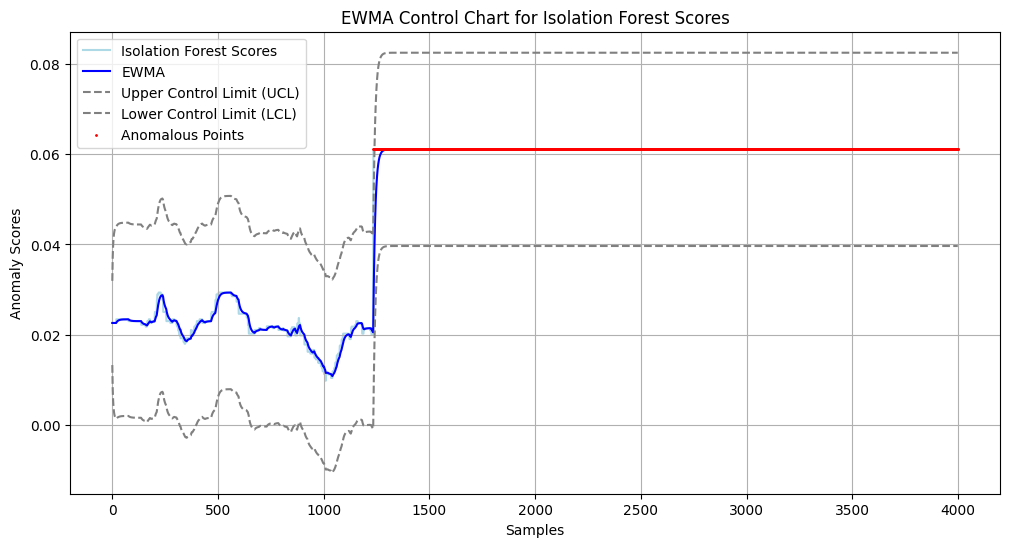

In [74]:
# Método para classificar os pontos com base nos limites de controle
def classify_points(scores, ewma, ucl, lcl):
    categories = []
    for i in range(len(scores)):
        if scores[i] > ucl[i]:
            categories.append('Anomalous')
        elif scores[i] < lcl[i]:
            categories.append('Normal')
        else:
            categories.append('Attention Needed')
    return categories


# Obter os escores de anomalia
# test_sample_ewma = test.sample(frac=0.0002, random_state=52).reset_index(drop=True)
# test_sample_ewma = spc_sample_test.reset_index(drop=True)#.sample(frac=0.0002, random_state=52).reset_index(drop=True)
# test_sample_ewma = spc_sample_test.sample(frac=0.1, random_state=52).reset_index(drop=True)

split_index = int(0.32 * len(spc_sample_test))
test_sample_ewma = spc_sample_test.iloc[split_index-4000:split_index].reset_index(drop=True)

escores = test_sample_ewma['scores_forest']

# Definir parâmetros EWMA
lambda_ = 0.1  # Fator de suavização, geralmente entre 0.1 e 0.3
L = 3  # Multiplicador para limites de controle

# Calcular EWMA
ewma = np.zeros_like(escores)
ewma[0] = escores[0]
for i in range(1, len(escores)):
    ewma[i] = lambda_ * escores[i] + (1 - lambda_) * ewma[i-1]

# Calcular desvio padrão dos escores
# sigma = np.std(escores)

# Calcular limites de controle
# ucl = ewma + L * sigma * np.sqrt(lambda_ / (2 - lambda_))
# lcl = ewma - L * sigma * np.sqrt(lambda_ / (2 - lambda_))

n = len(ewma)
ucl = ewma + L * sigma * np.sqrt((lambda_ / (2 - lambda_)) * (1 - (1 - lambda_)**(2 * (np.arange(n) + 1))))
lcl = ewma - L * sigma * np.sqrt((lambda_ / (2 - lambda_)) * (1 - (1 - lambda_)**(2 * (np.arange(n) + 1))))


# Classificar os pontos com base nos limites de controle
categories = classify_points(escores, ewma, ucl, lcl)

anomaous_target = test_sample_ewma.target.tolist()
# anomalous_indices = [i for i in range(len(categories)) if categories[i] == 'Anomalous']
anomalous_indices = [i for i in range(len(anomaous_target)) if anomaous_target[i] == 1]

# Plotar os gráficos de controle EWMA para os escores do Isolation Forest
plt.figure(figsize=(12, 6))
plt.plot(escores, label='Isolation Forest Scores', color='lightblue',  zorder=1)
plt.plot(ewma, label='EWMA', color='blue',  zorder=2)
plt.plot(ucl, 'r--', label='Upper Control Limit (UCL)', color='gray',  zorder=3)
plt.plot(lcl, 'r--', label='Lower Control Limit (LCL)', color='gray',  zorder=3)
# plt.scatter(anomalous_indices, [ewma[i] for i in anomalous_indices], color='red', label='Anomalous Points')
# plt.scatter(anomalous_indices, [escores[i] for i in anomalous_indices], color='red', label='Anomalous Points')
plt.scatter(anomalous_indices, [escores[i] for i in anomalous_indices], color='red', label='Anomalous Points', s=1, zorder=4)
plt.xlabel('Samples')
plt.ylabel('Anomaly Scores')
plt.title('EWMA Control Chart for Isolation Forest Scores')
plt.legend()
plt.grid(True)
plt.show()


In [57]:
# first_date = test_sample_ewma['timestamp'].min()
# last_date = test_sample_ewma['timestamp'].max()

# first_year = first_date.year
# first_month = first_date.month

# last_year = last_date.year
# last_month = last_date.month

In [58]:
# from datetime import datetime

In [59]:
# # Método para classificar os pontos com base nos limites de controle
# def classify_points(scores, ucl, lcl):
#     categories = []
#     for i in range(len(scores)):
#         if scores[i] > ucl[i]:
#             categories.append('Anomalous')
#         elif scores[i] < lcl[i]:
#             categories.append('Normal')
#         else:
#             categories.append('Attention Needed')
#     return categories

# # Obter os escores de anomalia
# escores = test_sample_ewma['scores_forest']



# # Definir parâmetros EWMA
# lambda_ = 0.1  # Fator de suavização, geralmente entre 0.1 e 0.3
# L = 3  # Multiplicador para limites de controle

# # Inicializar EWMA
# ewma = np.zeros_like(escores)
# ewma[0] = escores[0]


# # Calcular limites de controle
# n = len(ewma)
# ucl = np.zeros(n)
# lcl = np.zeros(n)

# ucl[0] = ewma[0] + L * sigma * np.sqrt((lambda_ / (2 - lambda_)))
# lcl[0] = ewma[0] - L * sigma * np.sqrt((lambda_ / (2 - lambda_)))

# # Calcular EWMA ignorando os pontos de anomalia
# for i in range(1, len(escores)):
#     # Usar o último valor do EWMA se o ponto anterior for uma anomalia
#     if escores[i-1] <= ucl[i-1] and escores[i-1] >= lcl[i-1]:
#         ewma[i] = lambda_ * escores[i] + (1 - lambda_) * ewma[i-1]
#     else:
#         ewma[i] = ewma[i-1]  # Manter o EWMA anterior se o ponto for uma anomalia
    
#     # Atualizar limites de controle
#     ucl[i] = ewma[i] + L * sigma * np.sqrt((lambda_ / (2 - lambda_)) * (1 - (1 - lambda_)**(2 * (i + 1))))
#     lcl[i] = ewma[i] - L * sigma * np.sqrt((lambda_ / (2 - lambda_)) * (1 - (1 - lambda_)**(2 * (i + 1))))

# # Classificar os pontos com base nos limites de controle
# categories = classify_points(escores, ucl, lcl)


# # Identificar índices de anomalias
# anomalous_indices = [i for i in range(len(categories)) if categories[i] == 'Anomalous']

# # Plotar os gráficos de controle EWMA para os escores do Isolation Forest
# plt.figure(figsize=(12, 6))
# plt.plot(escores, label='Isolation Forest Scores', color='lightblue', zorder=1)
# plt.plot(ewma, label='EWMA', color='blue', zorder=2)
# plt.plot(ucl, 'r--', label='Upper Control Limit (UCL)', color='gray', zorder=3)
# plt.plot(lcl, 'r--', label='Lower Control Limit (LCL)', color='gray', zorder=3)
# plt.scatter(anomalous_indices, [escores[i] for i in anomalous_indices], color='red', label='Anomalous Points', s=1, zorder=4)
# plt.xlabel('Samples')
# plt.ylabel('Anomaly Scores')
# plt.title('EWMA Control Chart for Isolation Forest Scores')
# plt.legend()
# plt.grid(True)
# plt.show()


In [54]:
# fig = go.Figure()

# fig.add_trace(go.Scatter(
#     x=list(range(len(escores))),
#     y=escores,
#     mode='lines',
#     name='Isolation Forest Scores',
#     line=dict(color='lightblue'),
#     zorder=1
# ))

# fig.add_trace(go.Scatter(
#     x=list(range(len(ewma))),
#     y=ewma,
#     mode='lines',
#     name='EWMA',
#     line=dict(color='blue'),
#     zorder=2
# ))

# fig.add_trace(go.Scatter(
#     x=list(range(len(ucl))),
#     y=ucl,
#     mode='lines',
#     name='Upper Control Limit (UCL)',
#     line=dict(color='gray', dash='dash'),
#     zorder=3
# ))

# fig.add_trace(go.Scatter(
#     x=list(range(len(lcl))),
#     y=lcl,
#     mode='lines',
#     name='Lower Control Limit (LCL)',
#     line=dict(color='gray', dash='dash'),
#     zorder=3
# ))

# fig.add_trace(go.Scatter(
#     x=anomalous_indices,
#     y=[escores[i] for i in anomalous_indices],
#     mode='markers',
#     name='Anomalous Points',
#     marker=dict(color='red', size=6),
#     zorder=4
# ))

# fig.update_layout(
#     # title='EWMA Control Chart for Isolation Forest Scores',
#     xaxis_title='Samples',
#     yaxis_title='Anomaly Scores',
#     legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1)
# )

# fig.show()

In [75]:
test_sample_ewma.shape

(4000, 12)

In [76]:
exp = shap.TreeExplainer(iforest[2]) #Explainer
test_transform = iforest[1].transform((iforest[0].transform(test_sample_ewma[VARS])))
shap_values = exp.shap_values(test_transform)  #Calculate SHAP values
shap.initjs()

In [56]:
# explainer = shap.TreeExplainer(iforest)
# shap_values = explainer.shap_values(test_sample_ewma[VARS])

In [66]:
# shap.initjs()
# shap.force_plot(exp.expected_value, shap_values[:,:], test_sample_ewma[VARS].iloc[:,:])

In [77]:
shap.initjs()
shap.force_plot(exp.expected_value, shap_values[:,:], test_transform[VARS].iloc[:,:])

In [42]:
test_sample_ewma['ucl'] = ucl 
test_sample_ewma['lcl'] = lcl
test_sample_ewma['ewma'] = ewma

In [43]:
test_sample_ewma['categories'] = categories

In [44]:
pd.crosstab(test_sample_ewma.target, test_sample_ewma.categories)

categories  Anomalous  Attention Needed
target                                 
0                   0            162890
1                   6             95940

In [45]:
pd.crosstab(test_sample_ewma.target, test_sample_ewma.categories, normalize=True)

categories  Anomalous  Attention Needed
target                                 
0            0.000000          0.629317
1            0.000023          0.370659

In [37]:
# metrics(test_sample_ewma.target, test_sample_ewma.categories)

In [46]:
test_sample_ewma[(test_sample_ewma['target']==1)&(test_sample_ewma['scores_forest']>=0)&(test_sample_ewma['categories']=='Anomalous')]

P-PDG       P-TPT     T-TPT   P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  \
162890 -1.180116e+42  20813670.0  117.8476  10136810.0   70.83952   4040100.0   
162891 -1.180116e+42  20813610.0  117.8475  10136690.0   70.83950   4040100.0   
162892 -1.180116e+42  20813560.0  117.8474  10136560.0   70.83949   4040100.0   
162893 -1.180116e+42  20813500.0  117.8473  10136440.0   70.83947   4040100.0   
162894 -1.180116e+42  20813450.0  117.8472  10136320.0   70.83945   4040101.0   
162895 -1.180116e+42  20813390.0  117.8471  10136200.0   70.83943   4040101.0   

        QGL           timestamp        well  target  iForest  scores_forest  \
162890  0.0 2018-06-17 18:13:15  WELL-00006       1        1       0.061114   
162891  0.0 2018-06-17 18:13:16  WELL-00006       1        1       0.061114   
162892  0.0 2018-06-17 18:13:17  WELL-00006       1        1       0.061114   
162893  0.0 2018-06-17 18:13:18  WELL-00006       1        1       0.061114   
162894  0.0 2018-06-17 18:13:19  WELL-00006       1        1       0.061114   
162895  0.0 2018-06-17 18:13:20  WELL-00006       1        1       0.061114   

             ucl       lcl      ewma categories  
162890  0.046027  0.003131  0.024579  Anomalous  
162891  0.049681  0.006785  0.028233  Anomalous  
162892  0.052969  0.010073  0.031521  Anomalous  
162893  0.055928  0.013032  0.034480  Anomalous  
162894  0.058592  0.015696  0.037144  Anomalous  
162895  0.060989  0.018093  0.039541  Anomalous

In [47]:
test_sample_ewma[(test_sample_ewma['target']==1)&(test_sample_ewma['scores_forest']>=0)].shape

(95946, 16)

In [48]:
test_sample_ewma[(test_sample_ewma['target']==1)&(test_sample_ewma['scores_forest']<0)].shape

(0, 16)

In [49]:
test_sample_ewma[test_sample_ewma['target']==1].head(30)

P-PDG       P-TPT     T-TPT   P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  \
162890 -1.180116e+42  20813670.0  117.8476  10136810.0   70.83952   4040100.0   
162891 -1.180116e+42  20813610.0  117.8475  10136690.0   70.83950   4040100.0   
162892 -1.180116e+42  20813560.0  117.8474  10136560.0   70.83949   4040100.0   
162893 -1.180116e+42  20813500.0  117.8473  10136440.0   70.83947   4040100.0   
162894 -1.180116e+42  20813450.0  117.8472  10136320.0   70.83945   4040101.0   
162895 -1.180116e+42  20813390.0  117.8471  10136200.0   70.83943   4040101.0   
162896 -1.180116e+42  20813340.0  117.8470  10136080.0   70.83942   4040101.0   
162897 -1.180116e+42  20813280.0  117.8469  10135960.0   70.83940   4040102.0   
162898 -1.180116e+42  20813220.0  117.8468  10135840.0   70.83939   4040102.0   
162899 -1.180116e+42  20813170.0  117.8467  10135720.0   70.83936   4040102.0   
162900 -1.180116e+42  20813110.0  117.8466  10135600.0   70.83935   4040102.0   
162901 -1.180116e+42  20813060.0  117.8465  10135480.0   70.83933   4040102.0   
162902 -1.180116e+42  20813000.0  117.8464  10135360.0   70.83931   4040102.0   
162903 -1.180116e+42  20812950.0  117.8462  10135240.0   70.83929   4040103.0   
162904 -1.180116e+42  20812890.0  117.8461  10135120.0   70.83928   4040103.0   
162905 -1.180116e+42  20812840.0  117.8460  10135000.0   70.83926   4040103.0   
162906 -1.180116e+42  20812780.0  117.8459  10134880.0   70.83924   4040103.0   
162907 -1.180116e+42  20812730.0  117.8458  10134760.0   70.83923   4040104.0   
162908 -1.180116e+42  20812670.0  117.8457  10134640.0   70.83921   4040104.0   
162909 -1.180116e+42  20812620.0  117.8456  10134510.0   70.83920   4040104.0   
162910 -1.180116e+42  20812560.0  117.8455  10134390.0   70.83917   4040104.0   
162911 -1.180116e+42  20812500.0  117.8454  10134270.0   70.83916   4040104.0   
162912 -1.180116e+42  20812450.0  117.8453  10134150.0   70.83914   4040105.0   
162913 -1.180116e+42  20812390.0  117.8452  10134030.0   70.83913   4040105.0   
162914 -1.180116e+42  20812340.0  117.8451  10133910.0   70.83910   4040105.0   
162915 -1.180116e+42  20812280.0  117.8450  10133790.0   70.83909   4040105.0   
162916 -1.180116e+42  20812230.0  117.8449  10133670.0   70.83907   4040105.0   
162917 -1.180116e+42  20812170.0  117.8448  10133550.0   70.83905   4040105.0   
162918 -1.180116e+42  20812120.0  117.8447  10133430.0   70.83904   4040106.0   
162919 -1.180116e+42  20812060.0  117.8446  10133310.0   70.83902   4040106.0   

        QGL           timestamp        well  target  iForest  scores_forest  \
162890  0.0 2018-06-17 18:13:15  WELL-00006       1        1       0.061114   
162891  0.0 2018-06-17 18:13:16  WELL-00006       1        1       0.061114   
162892  0.0 2018-06-17 18:13:17  WELL-00006       1        1       0.061114   
162893  0.0 2018-06-17 18:13:18  WELL-00006       1        1       0.061114   
162894  0.0 2018-06-17 18:13:19  WELL-00006       1        1       0.061114   
162895  0.0 2018-06-17 18:13:20  WELL-00006       1        1       0.061114   
162896  0.0 2018-06-17 18:13:21  WELL-00006       1        1       0.061114   
162897  0.0 2018-06-17 18:13:22  WELL-00006       1        1       0.061114   
162898  0.0 2018-06-17 18:13:23  WELL-00006       1        1       0.061114   
162899  0.0 2018-06-17 18:13:24  WELL-00006       1        1       0.061114   
162900  0.0 2018-06-17 18:13:25  WELL-00006       1        1       0.061114   
162901  0.0 2018-06-17 18:13:26  WELL-00006       1        1       0.061114   
162902  0.0 2018-06-17 18:13:27  WELL-00006       1        1       0.061114   
162903  0.0 2018-06-17 18:13:28  WELL-00006       1        1       0.061114   
162904  0.0 2018-06-17 18:13:29  WELL-00006       1        1       0.061114   
162905  0.0 2018-06-17 18:13:30  WELL-00006       1        1       0.061114   
162906  0.0 2018-06-17 18:13:31  WELL-00006       1        1       0.061114   
162907  0.0 2018-06-17 18:13:32  WELL-00006       1        1       0.061114   
16

In [42]:
test_sample_ewma.shape

(444, 16)

In [43]:
test_sample_ewma_attention = test_sample_ewma[test_sample_ewma['categories']=='Attention Needed']
test_sample_ewma_attention = test_sample_ewma_attention[VARS]

In [44]:
explainer = shap.TreeExplainer(iforest)
shap_values = explainer.shap_values(test_sample_ewma_attention)

In [45]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:,:], test_sample_ewma_attention[VARS].iloc[:,:])

In [46]:
test_sample_ewma_attention = test_sample_ewma[test_sample_ewma['categories']=='Normal']
test_sample_ewma_attention = test_sample_ewma_attention[VARS]

In [47]:
explainer = shap.TreeExplainer(iforest)
shap_values = explainer.shap_values(test_sample_ewma_attention)

In [48]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:,:], test_sample_ewma_attention[VARS].iloc[:,:])

In [49]:
test_sample_ewma_anomalous = test_sample_ewma[test_sample_ewma['categories']=='Anomalous']
test_sample_ewma_anomalous = test_sample_ewma_anomalous[VARS]

In [50]:
explainer = shap.TreeExplainer(iforest)
shap_values = explainer.shap_values(test_sample_ewma_anomalous)

In [51]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:,:], test_sample_ewma_attention[VARS].iloc[:,:])

In [ ]:
# for i in anomalous_indices[:5]:  
#     shap.force_plot(explainer.expected_value, shap_values[i], test_sample_ewma[VARS].iloc[i], matplotlib=True)

# # Exibir gráfico de resumo SHAP para todas as anomalias
# shap.summary_plot(shap_values, test_sample_ewma[VARS])

In [ ]:
test_sample_ewma.head()

### EWMA para valores SHAP das variáveis 

In [52]:
# Função para calcular EWMA
def calculate_ewma(values, lambda_):
    ewma_values = np.zeros_like(values)
    ewma_values[0] = values[0]
    for i in range(1, len(values)):
        ewma_values[i] = lambda_ * values[i] + (1 - lambda_) * ewma_values[i-1]
    return ewma_values

# Função para calcular UCL e LCL
def calculate_control_limits(ewma_values, std_ewma, L=3):
    mean_ewma = np.mean(ewma_values)
    # std_ewma = np.std(ewma_values)
    ucl = mean_ewma + L * std_ewma
    lcl = mean_ewma - L * std_ewma
    return ucl, lcl

    # Calcular o desvio padrão dos escores no conjunto de treino sem anomalias
train_sample_ewma = train[train['target'] == 0].sample(frac=0.01, random_state=51).reset_index(drop=True)
# escores_train = -train_sample_ewma['scores_forest']
# Calcular valores SHAP
explainer = shap.TreeExplainer(iforest)
shap_values_train = explainer.shap_values(train_sample_ewma[VARS])


test_sample_ewma = test.sample(frac=0.0002, random_state=52).reset_index(drop=True)
# escores = -test_sample_ewma['scores_forest']


# Calcular valores SHAP
explainer = shap.TreeExplainer(iforest)
shap_values = explainer.shap_values(test_sample_ewma[VARS])

In [53]:
# Definir parâmetros EWMA
lambda_ = 0.2  # Fator de suavização, geralmente entre 0.1 e 0.3
L = 3  # Multiplicador para limites de controle

# Calcular EWMA para cada variável preditora
shap_ewma = np.apply_along_axis(calculate_ewma, 0, shap_values, lambda_)

anomaous_target = test_sample_ewma.target.tolist()
# anomalous_indices = [i for i in range(len(categories)) if categories[i] == 'Anomalous']
anomalous_indices = [i for i in range(len(anomaous_target)) if anomaous_target[i] == 1]

# # Visualizar os resultados com UCL e LCL
# for i in range(shap_ewma.shape[1]):
#     plt.figure(figsize=(12, 6))
#     plt.plot(shap_values[:, i], label=f'SHAP values for feature {VARS[i]}', color='lightblue', zorder=1)
    
#     plt.plot(shap_ewma[:, i], label=f'EWMA of SHAP values for feature {VARS[i]}', color='orange', zorder=2)


#     shap_ewma_train = np.apply_along_axis(calculate_ewma, 0, shap_values_train[:, i], lambda_)
#     sigma_i = np.std(shap_ewma_train)
    
#     # Calcular UCL e LCL
#     # ucl, lcl = calculate_control_limits(shap_ewma[:, i], sigma_i, L=3)
#     ucl = shap_ewma[:, i] + L * sigma_i * np.sqrt(lambda_ / (2 - lambda_))
#     lcl = shap_ewma[:, i] - L * sigma_i * np.sqrt(lambda_ / (2 - lambda_))

#     plt.plot(ucl, 'r--', label='Upper Control Limit (UCL)', color='gray',  zorder=3)
#     plt.plot(lcl, 'r--', label='Lower Control Limit (LCL)', color='gray',  zorder=3)
    
#     plt.scatter(anomalous_indices, [escores[i] for i in anomalous_indices], color='red', label='Anomalous Points', s=10, zorder=4)
#     plt.xlabel('Samples')
#     plt.ylabel('SHAP values')
#     plt.title(f'EWMA of SHAP values for feature {VARS[i]}')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

In [54]:
# Loop para criar gráficos para cada característica
for i in range(shap_ewma.shape[1]):
    fig = go.Figure()

    # Adicionar SHAP values
    fig.add_trace(go.Scatter(
        x=list(range(len(shap_values))),
        y=shap_values[:, i],
        mode='lines',
        name=f'SHAP values for feature {VARS[i]}',
        line=dict(color='lightblue'),
        zorder=1
    ))

    # Adicionar EWMA dos SHAP values
    fig.add_trace(go.Scatter(
        x=list(range(len(shap_ewma))),
        y=shap_ewma[:, i],
        mode='lines',
        name=f'EWMA of SHAP values for feature {VARS[i]}',
        line=dict(color='orange'),
        zorder=2
    ))

    # Calcular UCL e LCL
    shap_ewma_train = np.apply_along_axis(calculate_ewma, 0, shap_values_train[:, i], lambda_)
    sigma_i = np.std(shap_ewma_train)
    ucl = shap_ewma[:, i] + L * sigma_i * np.sqrt(lambda_ / (2 - lambda_))
    lcl = shap_ewma[:, i] - L * sigma_i * np.sqrt(lambda_ / (2 - lambda_))


    fig.add_trace(go.Scatter(
        x=list(range(len(ucl))),
        y=ucl,
        mode='lines',
        name='Upper Control Limit (UCL)',
        line=dict(color='gray', dash='dash'),
        zorder=3
    ))

    fig.add_trace(go.Scatter(
        x=list(range(len(lcl))),
        y=lcl,
        mode='lines',
        name='Lower Control Limit (LCL)',
        line=dict(color='gray', dash='dash'),
        zorder=3
    ))

    fig.add_trace(go.Scatter(
        x=anomalous_indices,
        y=[shap_values[j, i] for j in anomalous_indices],
        mode='markers',
        name='Anomalous Points',
        marker=dict(color='red', size=6),  
        zorder=4
    ))

    fig.update_layout(
        title=f'EWMA of SHAP values for feature {VARS[i]}',
        xaxis_title='Samples',
        yaxis_title='SHAP values',
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1)
    )

    fig.show()